In [1]:
import numpy as np

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

In [13]:
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [2]:
class MLP:
    def __init__(self, params=None, layer_widths=None, max_iter=10000, learning_rate=0.01, tol=1e-3):
        self.layer_widths = layer_widths or [1, 128, 128, 1]
        self.params = params or MLP.init_params(self.layer_widths)
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.tol = tol

    @staticmethod
    def init_params(layer_widths):
        params = []
        for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
            params.append(
                dict(
                    weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
                    biases=np.ones(shape=(n_out,))
                )
            )
        return params

    @staticmethod
    def forward(params, x):
        *hidden, last = params
        for layer in hidden:
            x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
        return x @ last['weights'] + last['biases']

    @staticmethod
    def loss_fn(params, x, y):
        mse = jnp.mean((MLP.forward(params, x) - y) ** 2)
        return mse

    @staticmethod
    @jax.jit
    def sgd_update(params, x, y, learning_rate, tol):
        grads = jax.grad(MLP.loss_fn)(params, x, y)
        # Note that `grads` is a pytree with the same structure as `params`.
        # `jax.grad` is one of the many JAX functions that has
        # built-in support for pytrees.

        # This is handy, because we can apply the SGD update using tree utils:
        params = jax.tree_multimap(
            lambda p, g: p - learning_rate * g, params, grads
        )
        converged = jnp.all(jnp.array(
            jax.tree_map(lambda t: jnp.all(t < tol), jax.tree_leaves(grads))
        ))
        return params, converged


    def sgd(self, x, y):
        params, max_iter, tol, learning_rate = self.params, self.max_iter, self.tol, self.learning_rate

        iteration = 0
        converged = False
        while not converged and iteration < max_iter:
            params, converged = MLP.sgd_update(params, x, y, learning_rate, tol)
            iteration += 1

        if converged:
            print(f'SGD converged in {iteration} iterations!')

        self.params = params

    def fit(self, x, y):
        self.sgd(x, y)

    def predict(self, x):
        return MLP.forward(self.params, x)


In [3]:
n = 500
xtr = np.random.normal(size=(n, 1))
ytr = 1 / (1 + np.exp(-xtr))
# ytr = np.tanh(xtr)
# ytr = - xtr ** 2
# ytr = 1 / xtr
# ytr = np.sin(xtr)
# ytr = np.maximum(0, xtr)  # :thug_life:

In [4]:
layer_widths = [1, 128, 128, 1]
p0 = MLP.init_params(layer_widths)

In [5]:
max_iter = 3000
learning_rate = 9e-3
tol = 1e-3

mlp = MLP(params=p0, layer_widths=layer_widths, max_iter=max_iter, learning_rate=learning_rate, tol=tol)

In [6]:
mlp.fit(xtr, ytr)

In [7]:
yft = mlp.predict(xtr)

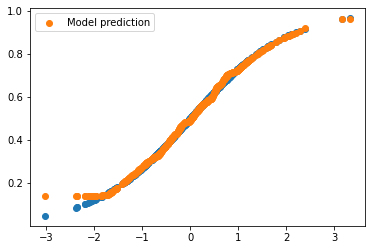

In [8]:
plt.scatter(xtr, ytr)
plt.scatter(xtr, yft, label='Model prediction')
plt.legend();

In [11]:
def train_mlp_timeit(p0):
    mlp.params = p0
    mlp.fit(xtr, ytr)

## CPU

In [18]:
%timeit train_mlp_timeit(p0)

1 loop, best of 5: 4.13 s per loop


## GPU

In [10]:
%timeit train_mlp_timeit(p0)

1 loop, best of 5: 2.41 s per loop


In [19]:
np.stack([xtr, ytr, yft], axis=1)[:5]

array([[[-0.10651088],
        [ 0.47339742],
        [ 0.47950381]],

       [[-1.92150423],
        [ 0.12769392],
        [ 0.14031935]],

       [[-0.65237694],
        [ 0.3424541 ],
        [ 0.33911571]],

       [[ 0.0261452 ],
        [ 0.50653593],
        [ 0.49789113]],

       [[-0.60756052],
        [ 0.35261588],
        [ 0.35157135]]])